In [5]:
from pathlib import Path
import xarray as xr
from hmpai.training import (
    split_data_on_participants,
    train_and_evaluate,
    get_compile_kwargs,
)
from hmpai.normalization import *
from hmpai.models import SAT1Base
import tensorflow as tf
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
import matplotlib.pyplot as plt
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import numpy as np
from tf_keras_vis.activation_maximization.callbacks import Progress
from mne.viz import plot_topomap
from mne.io import read_info
from tf_keras_vis.utils.input_modifiers import *
from tf_keras_vis.activation_maximization.regularizers import *

ImportError: cannot import name 'SAT1_STAGES_ACCURACY' from 'data' (unknown location)

### Activation Maximization

In [5]:
data_path = Path("data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)

In [33]:
train_data, val_data, test_data = split_data_on_participants(data, 60, norm_dummy)

In [34]:
model = SAT1Base(len(data.channels), len(data.samples), len(data.labels))
model.compile(**get_compile_kwargs())

In [ ]:
train_and_evaluate(
    model, train_data, val_data, test_data, epochs=5, logs_path=Path("../logs/"), workers=2
)

In [3]:
model = tf.keras.models.load_model("../models/cnn_base")

2023-10-06 13:05:58.534124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-06 13:05:58.565238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-06 13:05:58.565305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-06 13:05:58.567685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-06 13:05:58.567738: I tensorflow/compile

In [6]:
# Label 1
labels_idx = list(np.arange(0, len(data.labels)))
score = CategoricalScore(labels_idx)


def model_modifier(model):
    model.layers[-1].activation = tf.keras.activations.linear


def score_fn(output):
    return output[0, :]


positions = read_info(Path("../data/sat1/preprocessed/processed_0001_epo.fif"))
data_min = data.min().data.item()
data_max = data.max().data.item()

In [12]:
visualizer = ActivationMaximization(model, model_modifier, clone=True)

In [432]:
visualizer = Gradcam(model, model_modifier, clone=True)

In [456]:
visualizer = Saliency(model, model_modifier, clone=True)

In [13]:
seed_input_big = tf.random.uniform(
    (5, len(data.samples), len(data.channels), 1), -20, 20
)
activations = visualizer(
    score_fn,
    seed_input=seed_input_big,
    callbacks=[Progress()],
    input_range=(-20, 20),
    steps=2000,
    training=True,
    optimizer=tf.keras.optimizers.Nadam(),
    input_modifiers=[Jitter(1)],
    # input_modifiers=[],
    regularizers=[Norm(weight=0.3, p=1)],
)

2000/2000 [==============================] - 28s 14ms/step - Score: -4.6961 - Norm: 2.9442


In [102]:
# seed_input_big = tf.random.uniform((5, len(data.samples), len(data.channels), 1), data_min, data_max)
# activations = visualizer(
#     score,
#     seed_input=seed_input_big,
#     callbacks=[Progress()],
#     input_range=(data_min, data_max),
#     steps=500,
#     # training=True,
#     # optimizer=tf.keras.optimizers.Nadam(),
#     input_modifiers=[],
#     # input_modifiers=[],
#     # regularizers=[],
# )

500/500 [==============================] - 47s 94ms/step - Score: 33927.7383 - TotalVariation2D: 980.0490 - Norm: 132.3842


In [457]:
seed_input_big = tf.random.uniform((5, len(data.samples), len(data.channels), 1), 0, 1)
activations = visualizer(score, seed_input_big, smooth_samples=20, smooth_noise=0.20)

In [447]:
seed_input_big = tf.random.uniform((5, len(data.samples), len(data.channels), 1), 0, 1)
activations = visualizer(
    score, seed_input=seed_input_big, penultimate_layer=-10, training=False
)

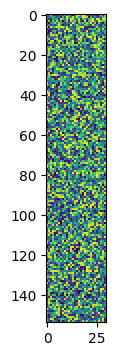

In [14]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
ax.imshow(activations[0])

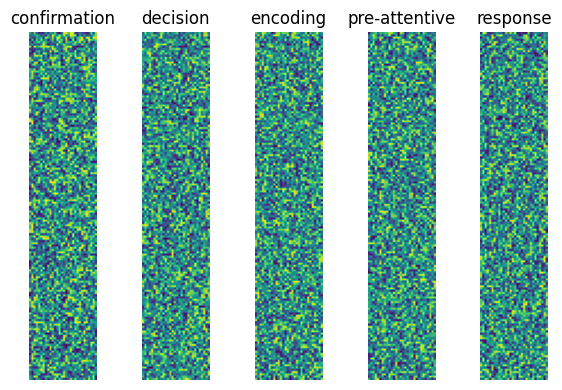

In [15]:
f, ax = plt.subplots(nrows=1, ncols=len(labels_idx), figsize=(6, 4))
for i, title in enumerate(data.labels):
    ax[i].set_title(title.item())
    ax[i].imshow(activations[i])
    ax[i].axis("off")
# ax.axis('off')
plt.tight_layout()
plt.show()

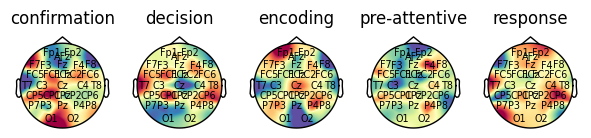

In [16]:
f, ax = plt.subplots(nrows=1, ncols=len(labels_idx), figsize=(6, 4))
timesteps = np.arange(0, len(data.samples), 10)
for label_idx in labels_idx:
    activations_new_mean = np.mean(
        np.squeeze(activations[label_idx]) - np.mean(np.squeeze(activations)), axis=0
    )
    # activations_new_mean = np.mean(np.squeeze(activations[label_idx]), axis=0)
    vmin = np.min(activations_new_mean)
    vmax = np.max(activations_new_mean)
    ax[label_idx].set_title(data.labels[label_idx].item())
    plot_topomap(
        activations_new_mean,
        positions,
        axes=ax[label_idx],
        show=False,
        cmap="Spectral_r",
        vlim=(vmin, vmax),
        sensors=False,
        contours=0,
        names=data.channels.to_numpy(),
    )
    # plt.title(data.labels[label_idx].item())
plt.tight_layout()
plt.show()

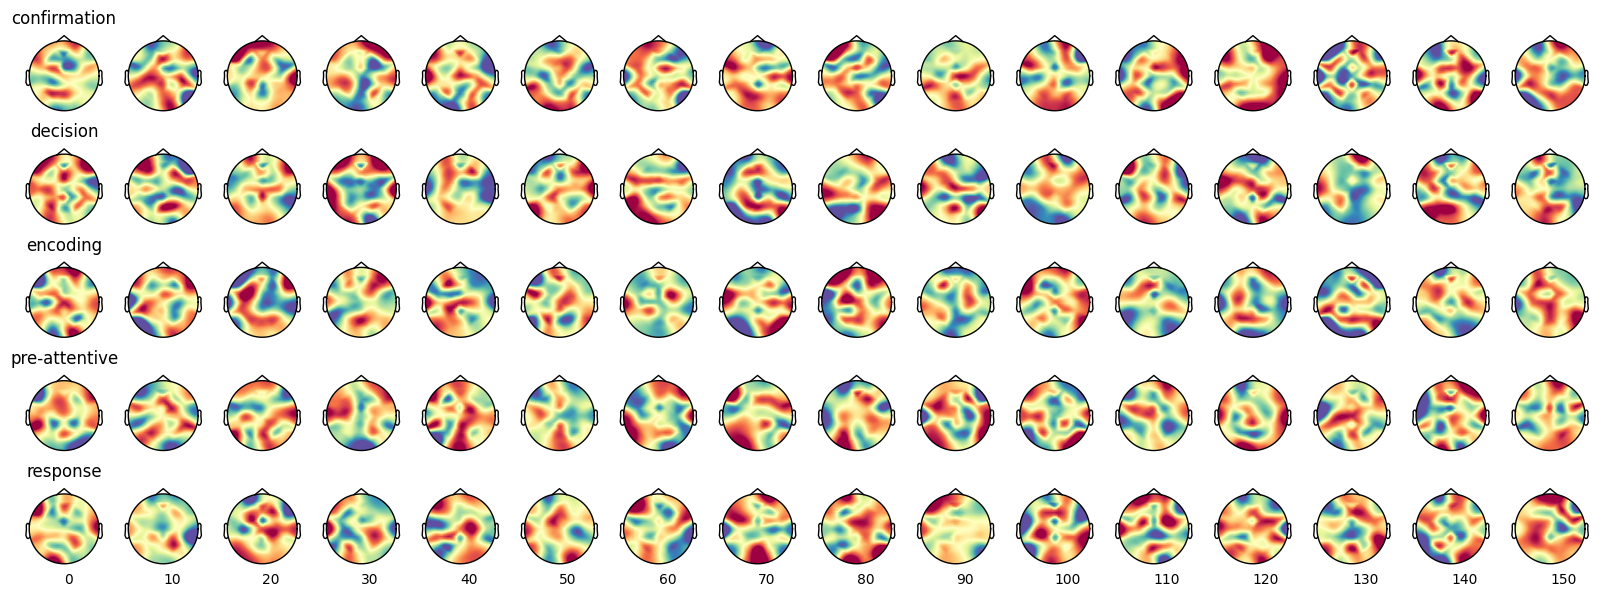

In [210]:
timesteps = np.arange(0, len(data.samples), 10)
f, axs = plt.subplots(
    nrows=len(labels_idx),
    ncols=len(timesteps),
    figsize=(len(timesteps), 6),
    sharex=True,
)
vmin = np.min(activations)
vmax = np.max(activations)
plt.setp(axs, xticks=timesteps)
for label_idx in labels_idx:
    axs[label_idx, 0].set_title(data.labels[label_idx].item())
    for i, timestep in enumerate(timesteps):
        # axs[i, label_idx].set_ylabels(str(timestep))

        activations_new = np.squeeze(activations[label_idx])
        # vmin = np.min(activations[:, timestep, :])
        # vmax = np.max(activations[:, timestep, :])
        plot_topomap(
            activations_new[timestep, :],
            positions,
            axes=axs[label_idx, i],
            show=False,
            cmap="Spectral_r",
            vlim=(vmin, vmax),
            sensors=False,
            contours=0,
            res=32,
        )
        if label_idx == labels_idx[-1]:
            axs[label_idx, i].text(0, -0.15, str(timestep))
plt.tight_layout()
plt.show()

In [ ]:
activations = []
for label in labels_idx:
    seed_input = tf.random.uniform((len(data.samples), len(data.channels), 1), 0, 1)
    activation = visualizer(
        CategoricalScore(label),
        seed_input=seed_input,
        penultimate_layer=-6,
        training=True,
    )
    print(label, activation)
    activations.append(np.squeeze(activation))
activations = np.array(activations)